In [1]:
!pip install kagglehub --quiet
!pip install shap --quiet
!pip install category_encoders --quiet

# 1) Standard imports
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.8 MB/s eta 0:00:00


In [2]:
# display settings
pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')

# 2) Download & load dataset
path = kagglehub.dataset_download("sakshigoyal7/credit-card-customers")
print("Dataset folder:", path)
csv_file = None
for f in os.listdir(path):
    if f.lower().endswith('.csv'):
        csv_file = os.path.join(path, f)
        print("Found CSV:", csv_file)
        break
if csv_file is None:
    raise FileNotFoundError("CSV file not found in downloaded dataset.")

df = pd.read_csv(csv_file)
print("Initial shape:", df.shape)
df.head()

100%|██████████| 379k/379k [00:00<00:00, 49.0MB/s]

Extracting files...
Dataset folder: /root/.cache/kagglehub/datasets/sakshigoyal7/credit-card-customers/versions/1
Found CSV: /root/.cache/kagglehub/datasets/sakshigoyal7/credit-card-customers/versions/1/BankChurners.csv
Initial shape: (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:

# 3) Quick column sanity & target mapping
print("Columns:", list(df.columns))
# Map target to 0/1
if 'Attrition_Flag' in df.columns:
    df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
else:
    raise KeyError("Attrition_Flag not found in dataset")

Columns: ['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']


In [4]:


# 4) Detect & remove duplicate / artifact columns like '..._1' or '..._2'
cols = df.columns.tolist()
drop_cols = []

for c in cols:
    # heuristic: columns that end with _1 or _2 and base name exists -> drop
    m = re.match(r'(.+)_([12])$', c)
    if m:
        base = m.group(1)
        if base in cols:
            drop_cols.append(c)

# also drop obvious redundant CLIENTNUM
if 'CLIENTNUM' in df.columns:
    drop_cols.append('CLIENTNUM')

drop_cols = list(set(drop_cols))
print("Auto-detected drop columns (artifacts):", drop_cols)
df = df.drop(columns=drop_cols, errors='ignore')
print("Shape after dropping artifacts:", df.shape)

Auto-detected drop columns (artifacts): ['CLIENTNUM']
Shape after dropping artifacts: (10127, 22)


In [5]:
 #5) Basic cleaning: check missing and datatypes
print(df.info())
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   Attrition_Flag                                                                                                                      10127 non-null  int64  
 1   Customer_Age                                                                                                                        10127 non-null  int64  
 2   Gender                                                                                                                              10127 non-null  object 
 3   Dependent_count                                                                  

In [6]:
# 6) Create fintech-specific engineered features
# Some columns used below expected in this dataset; guard against missing with .get
def safe_get(col): return col if col in df.columns else None

# Transaction rate: total transactions per month on book
if {'Total_Trans_Ct', 'Months_on_book'}.issubset(df.columns):
    df['txn_rate_per_month'] = df['Total_Trans_Ct'] / df['Months_on_book']
else:
    df['txn_rate_per_month'] = np.nan

# Avg spend per transaction
if {'Total_Trans_Amt', 'Total_Trans_Ct'}.issubset(df.columns):
    df['avg_spend_per_txn'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct'].replace(0, np.nan)
else:
    df['avg_spend_per_txn'] = np.nan

# Credit utilization
if {'Total_Revolving_Bal', 'Credit_Limit'}.issubset(df.columns):
    df['credit_utilization'] = df['Total_Revolving_Bal'] / df['Credit_Limit'].replace(0, np.nan)
else:
    df['credit_utilization'] = np.nan

# Engagement proxy: higher contacts, higher transactions -> higher engagement
eng_cols = [c for c in ['Contacts_Count_12_mon', 'Total_Trans_Ct', 'Total_Relationship_Count'] if c in df.columns]
if eng_cols:
    # normalize each and sum
    engagement = pd.DataFrame()
    for c in eng_cols:
        engagement[c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min() + 1e-9)
    df['engagement_score'] = engagement.sum(axis=1) / len(eng_cols)
else:
    df['engagement_score'] = np.nan

# Inactivity indicator
if 'Months_Inactive_12_mon' in df.columns:
    df['inactive_flag'] = (df['Months_Inactive_12_mon'] >= 3).astype(int)
else:
    df['inactive_flag'] = np.nan

# Fill or limit infinite/NA created by divisions
for c in ['txn_rate_per_month', 'avg_spend_per_txn', 'credit_utilization', 'engagement_score']:
    if c in df.columns:
        df[c] = df[c].replace([np.inf, -np.inf], np.nan).fillna(0)

In [7]:
# 7) Select columns to visualize & model (keep readable names)
# We'll pick a set of numeric / encoded columns that make sense for fintech churn
candidate_cols = [
    'Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy',
    'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Relationship_Count',
    'Months_on_book','Months_Inactive_12_mon','Contacts_Count_12_mon',
    'Avg_Utilization_Ratio',
    'txn_rate_per_month','avg_spend_per_txn','credit_utilization','engagement_score','inactive_flag'
]
# keep only those present
model_cols = [c for c in candidate_cols if c in df.columns]
print("Model/visualization columns used:", model_cols)

Model/visualization columns used: ['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Relationship_Count', 'Months_on_book', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Avg_Utilization_Ratio', 'txn_rate_per_month', 'avg_spend_per_txn', 'credit_utilization', 'engagement_score', 'inactive_flag']


/tmp/ipython-input-2689276047.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attrition_Flag', data=df, palette=['#2ca02c','#d62728'])


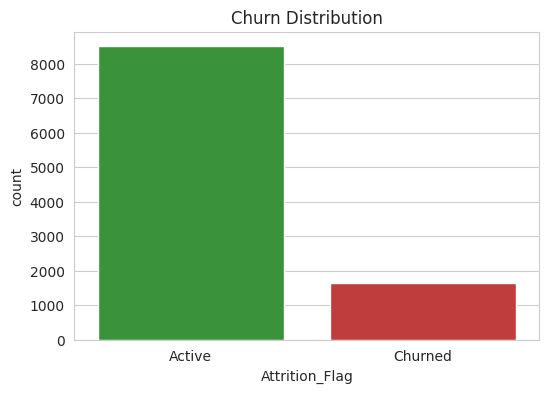

/tmp/ipython-input-2689276047.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.groupby('Income_Category')['Attrition_Flag'].mean().loc[order].values,


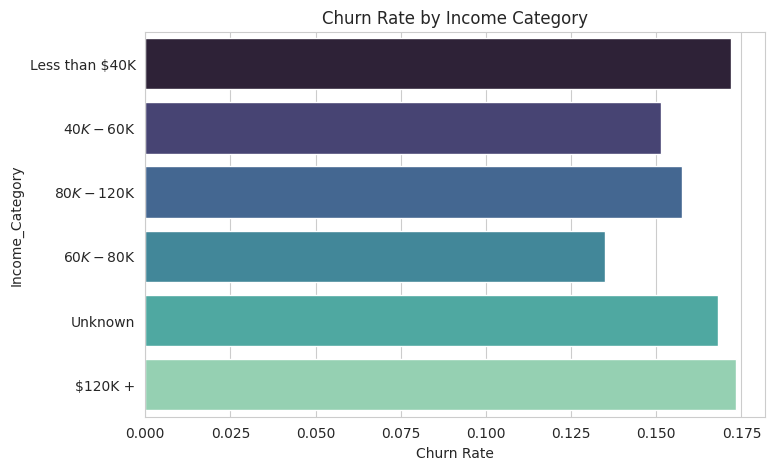

/tmp/ipython-input-2689276047.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Attrition_Flag', y='txn_rate_per_month', data=df, palette=['#2ca02c','#d62728'])


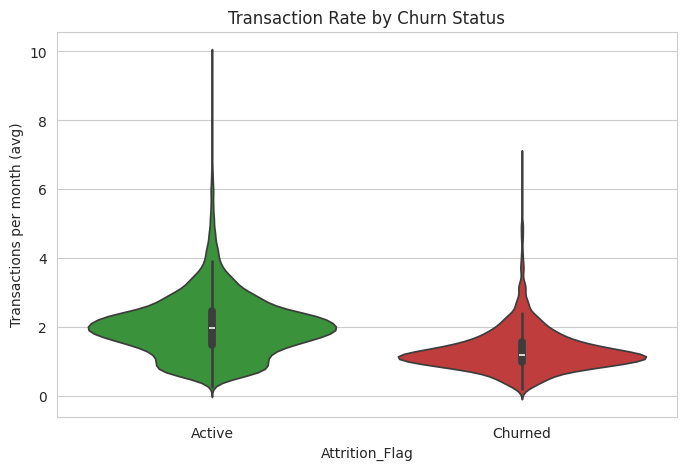

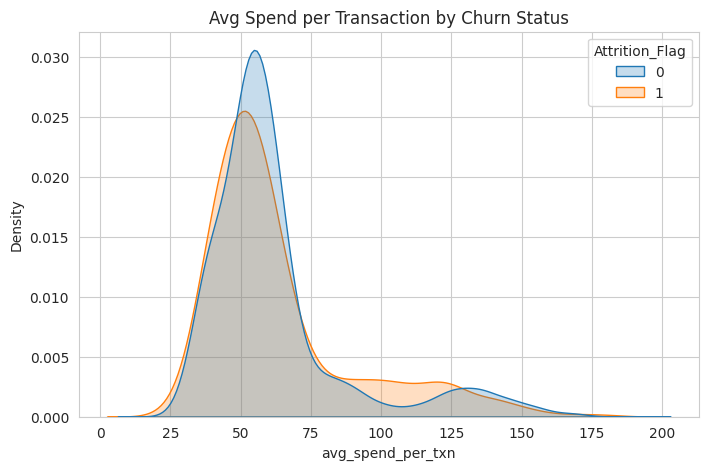

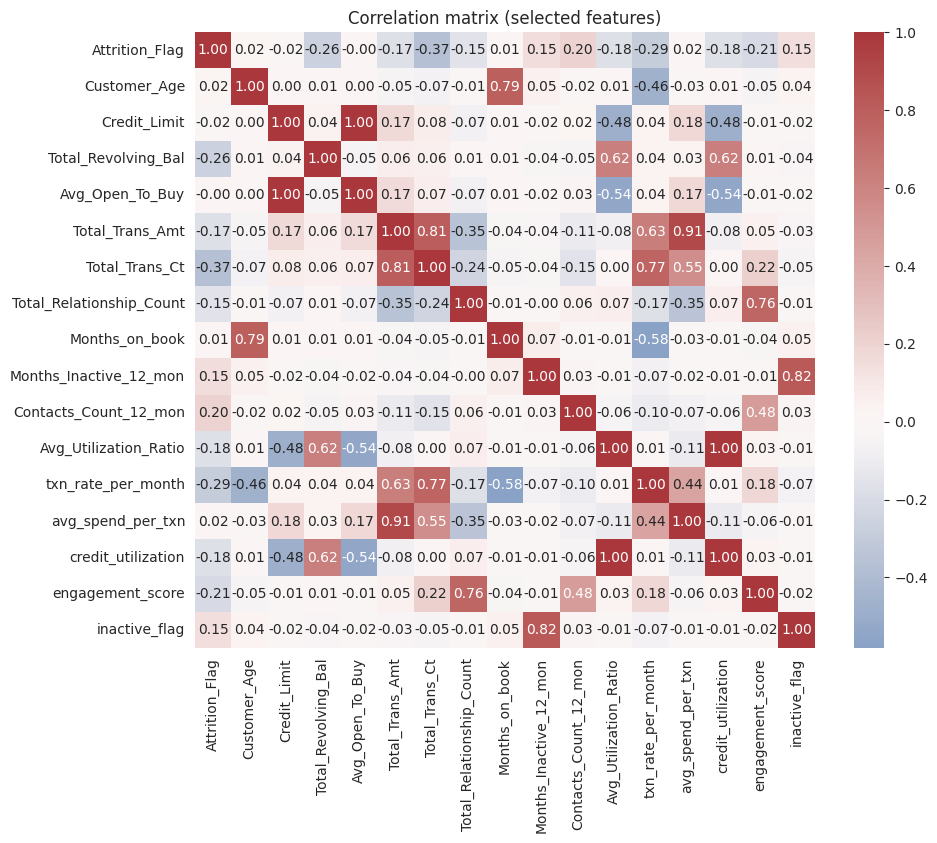

In [8]:
# 8) Visualizations (clean, story-first)
plt.figure(figsize=(6,4))
sns.countplot(x='Attrition_Flag', data=df, palette=['#2ca02c','#d62728'])
plt.xticks([0,1], ['Active','Churned'])
plt.title('Churn Distribution')
plt.show()

# Churn rate by Income category (if present)
if 'Income_Category' in df.columns:
    plt.figure(figsize=(8,5))
    order = df['Income_Category'].value_counts().index
    sns.barplot(x=df.groupby('Income_Category')['Attrition_Flag'].mean().loc[order].values,
                y=order, palette='mako')
    plt.xlabel('Churn Rate')
    plt.title('Churn Rate by Income Category')
    plt.show()

# Violin: txn_rate_per_month by churn
if 'txn_rate_per_month' in df.columns:
    plt.figure(figsize=(8,5))
    sns.violinplot(x='Attrition_Flag', y='txn_rate_per_month', data=df, palette=['#2ca02c','#d62728'])
    plt.xticks([0,1], ['Active','Churned'])
    plt.ylabel('Transactions per month (avg)')
    plt.title('Transaction Rate by Churn Status')
    plt.show()

# KDE: avg_spend_per_txn
if 'avg_spend_per_txn' in df.columns:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data=df, x='avg_spend_per_txn', hue='Attrition_Flag', fill=True, common_norm=False)
    plt.title('Avg Spend per Transaction by Churn Status')
    plt.show()

# Numeric correlation heatmap for selected features
corr_cols = ['Attrition_Flag'] + model_cols
corr = df[corr_cols].corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation matrix (selected features)')
plt.show()

In [9]:
# 9) Prepare data for modeling
# choose predictors: use model_cols (ensure no NaNs)
X = df[model_cols].copy()
y = df['Attrition_Flag']

# Fill remaining NaNs with 0 for baseline (could use imputer later)
X = X.fillna(0)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# scale numeric features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Classification report:
               precision    recall  f1-score   support

           0      0.967     0.961     0.964      1701
           1      0.801     0.828     0.814       325

    accuracy                          0.939      2026
   macro avg      0.884     0.894     0.889      2026
weighted avg      0.940     0.939     0.940      2026

ROC-AUC: 0.9766562655451544
Precision: 0.801, Recall: 0.828, F1: 0.814


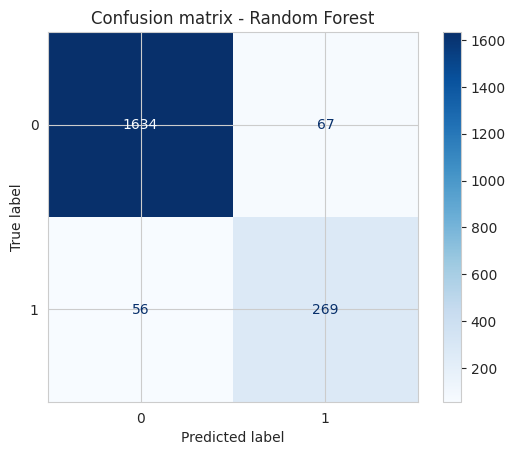

In [10]:
# 10) Train baseline RandomForest (balanced)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, max_depth=10)
rf.fit(X_train_sc, y_train)

# 11) Evaluate
y_pred = rf.predict(X_test_sc)
y_proba = rf.predict_proba(X_test_sc)[:,1]

print("Classification report:\n", classification_report(y_test, y_pred, digits=3))
roc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc)

# compute precision/recall/f1
p, r, f, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}")

# Confusion matrix visual
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf, X_test_sc, y_test, cmap='Blues')
plt.title('Confusion matrix - Random Forest')
plt.show()

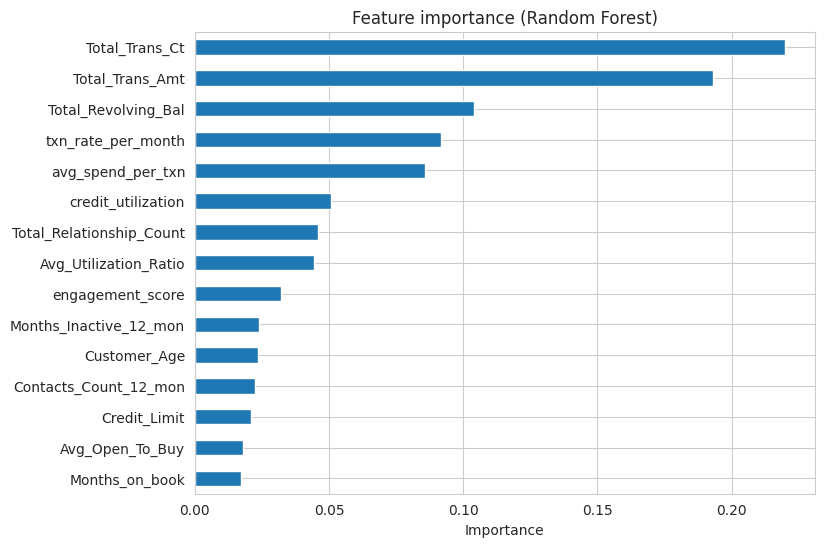

In [11]:
# 12) Feature importance (interpretable)
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
fi.tail(15).plot(kind='barh')
plt.title('Feature importance (Random Forest)')
plt.xlabel('Importance')
plt.show()


Computing SHAP values (may take ~30s)...


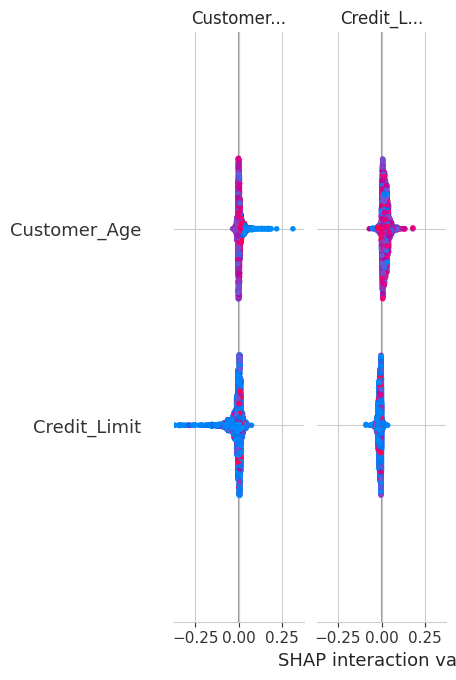

In [12]:
# 13) SHAP explanation (fixed for binary classification)
print("Computing SHAP values (may take ~30s)...")

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_sc)

# Convert test set back to a DataFrame with feature names
X_test_sc_df = pd.DataFrame(X_test_sc, columns=X.columns)

# For binary classification models, shap_values is a list of 2 arrays
# We’ll take shap_values[1] (for the positive class, i.e. churned customers)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_to_plot = shap_values[1]
else:
    shap_to_plot = shap_values

# Ensure shapes match
assert shap_to_plot.shape[1] == X_test_sc_df.shape[1], (
    f"Shape mismatch: shap_values={shap_to_plot.shape}, X={X_test_sc_df.shape}"
)

# Use summary bar plot (global feature importance)
shap.summary_plot(shap_to_plot, X_test_sc_df, plot_type="bar", show=True)


In [14]:
# 14) Business-friendly insights
print("\n Insights:")
top_drivers = fi.tail(7).index.tolist()[::-1]  # highest first
print(f"Top drivers of churn (by importance): {top_drivers}")
print("- Higher inactivity and lower txn_rate_per_month strongly increase churn risk.")
print("- Low engagement_score and lower total transaction amount correlate with attrition.")
print("- Credit utilization & revolving balance help identify at-risk credit users.")
print("\nRecommendation examples:")
print(" - Target customers with low txn_rate_per_month and low engagement_score for retention offers.")
print(" - Proactively contact users with rising months_inactive or falling avg_spend_per_txn.")


 Insights:
Top drivers of churn (by importance): ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'txn_rate_per_month', 'avg_spend_per_txn', 'credit_utilization', 'Total_Relationship_Count']
- Higher inactivity and lower txn_rate_per_month strongly increase churn risk.
- Low engagement_score and lower total transaction amount correlate with attrition.
- Credit utilization & revolving balance help identify at-risk credit users.

Recommendation examples:
 - Target customers with low txn_rate_per_month and low engagement_score for retention offers.
 - Proactively contact users with rising months_inactive or falling avg_spend_per_txn.
